<a href="https://colab.research.google.com/github/ashwinvaswani/Generative-Modelling-of-Images-from-Speech/blob/master/src/TIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub
!pip install pytube
!pip install mtcnn
!pip install keras-vggface

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Created wheel for mtcnn: filename=mtcnn-0.0.9-cp36-none-any.whl size=2257690 sha256=4f129b2449d3eb7ee3c9c4ed5a0b480772c8c592f0cf47f96ed52ebecabedbd6
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn


In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2 
import os
import sys
import moviepy.editor as mp
import pickle

import math
from math import ceil
from math import floor

from pydub import AudioSegment
from pytube import YouTube

import shutil

import IPython.display as ipd
import librosa
import librosa.display

import dlib

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1818624/45929032 bytes (4.0%)5734400/45929032 bytes (12.5%)9650176/45929032 bytes (21.0%)13574144/45929032 bytes (29.6%)17522688/45929032 bytes (38.2%)21454848/45929032 bytes (46.7%)25354240/45929032 bytes (55.2%)29270016/45929032 bytes (63.7%)33169408/45929032 bytes (72.2%)37191680/45929032 bytes (81.0%)41066496/45929032 bytes (89.4%)45072384/45929032 bytes (98.1%)

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH = './drive/My Drive/TIP/Dataset/'
PATH_TO_MAIN = './drive/My Drive/TIP/'
YT_LINK = 'www.youtube.com/watch?v='

In [0]:
column_names = ['YouTube_ID', 'start_segment', 'end_segment', 'X_coordinate', 'Y_coordinate']
train_df = pd.read_csv(PATH + 'avspeech_train.csv',names = column_names)
test_df = pd.read_csv(PATH + 'avspeech_test.csv',names = column_names)

In [6]:
train_df.head()

,YouTube_ID,start_segment,end_segment,X_coordinate,Y_coordinate
0,CJoOwXcjhds,233.266000,239.367000,0.780469,0.670833
1,AvWWVOgaMlk,90.000000,93.566667,0.586719,0.311111
2,Y8HMIm8mdns,171.607767,174.607767,0.505729,0.240741
3,akwvpAiLFk0,144.680000,150.000000,0.698438,0.288889
4,Swss72CHSWg,90.023267,97.297200,0.230729,0.204630


In [7]:
test_df.head()

,YouTube_ID,start_segment,end_segment,X_coordinate,Y_coordinate
0,u5MPyrRJPmc,108.2400,111.240000,0.849219,0.305556
1,H1ulMfj5wRY,112.3200,116.940000,0.112500,0.345833
2,-wuxbgMRIWs,30.0300,36.745044,0.744531,0.211111
3,GNRPRH-E-sI,30.2302,38.171467,0.333594,0.494444
4,VvcwAGkSy2o,240.2000,253.366667,0.491667,0.372222


In [8]:
YT_LINK + train_df.iloc[2]["YouTube_ID"]

'www.youtube.com/watch?v=Y8HMIm8mdns'

In [9]:

# shutil.rmtree('Images')
# shutil.rmtree('Audio')
# shutil.rmtree('Videos')
os.mkdir("Images")
os.mkdir("Audio")
os.mkdir("Videos")

len_train = train_df.shape[0]
count_unsuccessful = 0
dict_audio = {}

for i in range(1,2):

  print(YT_LINK + train_df.iloc[i]["YouTube_ID"])
  try:
    yt = YouTube(YT_LINK + train_df.iloc[i]["YouTube_ID"])
    stream = yt.streams.first()
    stream.download(output_path = 'Videos/',filename = train_df.iloc[i]["YouTube_ID"])


    cap = cv2.VideoCapture("Videos/" + train_df.iloc[i]["YouTube_ID"] + '.mp4') 
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    count = 0

    dir_name = train_df.iloc[i]["YouTube_ID"]
    # os.mkdir("Images/" + dir_name)
    
    print("FPS is : "  + str(fps))
    start_cnt = train_df.iloc[i]["start_segment"]
    end_cnt = train_df.iloc[i]["end_segment"]
    
    while(1):

        ret,frame = cap.read()

        if ret == 1:

          count += 1

          (h, w) = frame.shape[:2]


          # if count > ceil(ceil(start_cnt)*fps) and count < floor(floor(end_cnt)*fps):
          #   cv2.imwrite("Images/" + dir_name + "/frame%d.png" % count, frame)

          if (((start_cnt + end_cnt)*fps)/2) - 16 < count < (((start_cnt + end_cnt)*fps)/2) + 16:
            dnnFaceDetector = dlib.cnn_face_detection_model_v1( PATH_TO_MAIN + "Face_detection/mmod_human_face_detector.dat")
            faceRects = dnnFaceDetector(frame, 0)
            print(faceRects)
            for faceRect in faceRects:
                x1 = faceRect.rect.left()
                y1 = faceRect.rect.top()
                x2 = faceRect.rect.right()
                y2 = faceRect.rect.bottom()
                img = frame[y1:y2, x1:x2]
                print("About to crop")
                print(count)
                img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
                cv2.imwrite('Images/' +dir_name + '.png', img)
            break


          if count > int(end_cnt*fps):
            break
          k = cv2.waitKey(1)
          if k == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
  except:
    print("SORRY!!! The video is unavailable")
    count_unsuccessful += 1
    
  try:
    clip = mp.VideoFileClip("Videos/" + train_df.iloc[i]["YouTube_ID"] + '.mp4').subclip(start_cnt,end_cnt)
    clip.audio.write_audiofile("Audio/" + train_df.iloc[i]["YouTube_ID"] +'.mp3') 
    print("before dict")
    dict_audio[train_df.iloc[i]["YouTube_ID"]] = end_cnt - start_cnt
  except:
    print("Error with audio")  

www.youtube.com/watch?v=AvWWVOgaMlk
FPS is : 30.000015705169986
mmod_rectangles[[(532, 80) (871, 420)]]
About to crop
2738
[MoviePy] Writing audio in Audio/AvWWVOgaMlk.mp3


100%|██████████| 79/79 [00:00<00:00, 571.98it/s]

[MoviePy] Done.
before dict


In [0]:
# Augmenting audio 

In [120]:
shutil.rmtree('Processed_Audio')
os.mkdir('Processed_Audio')
temp_dict = dict_audio.copy()
for elem in os.listdir('./Audio'):
  sound = AudioSegment.from_mp3('./Audio/' + elem)
  sound_new = sound
  while temp_dict[elem[:-4]] < 6:
    print("here")
    sound_new += sound
    temp = temp_dict[elem[:-4]]
    temp_dict[elem[:-4]] = 2*temp
    sound = sound_new

  extract = sound[0:6*1000+1]

  extract.export('Processed_Audio/' + elem, format="mp3")


here


In [0]:
# Preparing y_train

In [0]:
def get_embeddings(filenames):

  faces = []
  for f in filenames:
    img = cv2.imread(f)
    face_arr = asarray(img)
    faces.append(face_arr)

  samples = asarray(faces,'float32')

  samples = preprocess_input(samples,version=2)

  model = VGGFace(model='resnet50',include_top=False,input_shape=(224,224,3),pooling='avg')

  yhat = model.predict(samples)

  return yhat

In [0]:
face_list = []
for elem in os.listdir('./Images'):
  face_list.append('./Images/' + elem)
y_train = get_embeddings(face_list)

In [15]:
y_train.shape

(1, 2048)

In [0]:
# Using y_train to create decoder

In [0]:
# Input is y_train and output is images from Images folder

In [0]:
# Preparing x_train

./Audio/AvWWVOgaMlk.mp3
<class 'numpy.ndarray'> <class 'int'>
(56800,) 15925


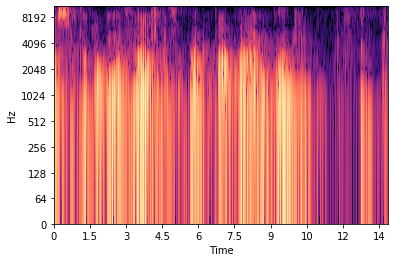

In [134]:
shutil.rmtree('Spectograms')
os.mkdir('Spectograms')
for filename in os.listdir("./Audio"):
  audio_path = './Audio/' + filename
  x , sr = librosa.load(audio_path,sr = 15925)
  print(audio_path)
  print(type(x), type(sr))
  print(x.shape, sr)
  ipd.Audio(audio_path)
  window_size = 25
  window = np.hanning(window_size)
  stft  = librosa.core.spectrum.stft(x, n_fft=512, hop_length=95,win_length=window_size, window=window)
  out = 2 * np.abs(stft) / np.sum(window_size)
  with open('./Spectograms/' + filename[:-4] + '.pkl','wb') as f:
    pickle.dump(out,f)
  
  # librosa.display.waveplot(x, sr=sr)
  # mfccs = librosa.feature.mfcc(x, sr=sr)
  # print(mfccs.shape)
  # librosa.display.specshow(mfccs, sr=sr, x_axis='time')
  # print()
  
  
  # X = librosa.stft(x)
  # Xdb = librosa.amplitude_to_db(abs(X))
  # fig = plt.Figure()
  # canvas = FigureCanvas(fig)
  # ax = fig.add_subplot(111)
  # p = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  # fig.savefig('./Spectograms/' + filename[:-4] + '.png')

  fig = plt.Figure()
  canvas = FigureCanvas(fig)
  # ax = fig.add_subplot(111)
  p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max), y_axis='log', x_axis='time')
  fig.savefig('./Spectograms/' + filename[:-4] + '.png')




In [0]:
# Todo: For all pickle files in spectogram folder

In [0]:
with open('./Spectograms/' + filename[:-4] + '.pkl','rb') as f:
    k = pickle.load(f)

In [137]:
k.shape

(257, 598)

In [0]:
def encoder_network_input(k):
  mod = np.zeros((257,598))
  for i in range(257):
    for j in range(598):
      mod[i][j] = np.abs(k[i][j])

  theta_ = np.zeros((257,598))
  for i in range(257):
    for j in range(598):
      theta_[i][j] = np.angle(k[i][j])

  for i in range(257):
    for j in range(598):
      temp = real[i][j]
      real[i][j] = temp * math.cos(complex_[i][j])
      complex_[i][j] = temp * math.sin(complex_[i][j])

  real = np.expand_dims(real,axis = 0)
  complex_ = np.expand_dims(complex_,axis = 0)
  combined = np.concatenate((real,complex_))

  return combined

In [0]:
encoder_input = 

In [0]:
from google.colab import files
files.download('/content/Processed_Audio/AvWWVOgaMlk.mp3')